<a href="https://colab.research.google.com/github/Sweekar-Bajimaya/Brain-Tumor-Classification/blob/main/Brain_Tumour_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation-20250509T070105Z-001.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import random
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import ResNet50, VGG16
import time

# **Data Understanding, Analysis, Visualization and Cleaning**

**What does the dataset represent? Provide a brief description.**

Ans: The dataset represents a collection of medical images for brain tumor classification, specifically MRI scans categorized into four classes: glioma tumor, meningioma tumor, pituitary tumor, and normal (no tumor). The dataset is organized into two main directories: train and test, each containing subdirectories for the four classes. This dataset is likely used for training and evaluating a machine learning model to classify brain tumors based on MRI images.

**How many total images are in the dataset?**


In [ ]:
base_path = "/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation"
splits = ["train", "test"]
classes = ["glioma_tumor", "meningioma_tumor", "normal", "pituitary_tumor"]

total_images = 0
for split in splits:
    for cls in classes:
        folder = f"{base_path}/{split}/{cls}"
        num_images = len(os.listdir(folder))
        total_images += num_images
print(f"Total images: {total_images}")

Total images: 3096


**What is the distribution of images across different classes?**

In [ ]:
for split in splits:
    print(f"\n{split} distribution:")
    for cls in classes:
        folder = f"{base_path}/{split}/{cls}"
        num_images = len(os.listdir(folder))
        print(f"{cls}: {num_images} images")


train distribution:
glioma_tumor: 720 images
meningioma_tumor: 730 images
normal: 350 images
pituitary_tumor: 675 images

test distribution:
glioma_tumor: 181 images
meningioma_tumor: 183 images
normal: 88 images
pituitary_tumor: 169 images


**Finding and deleting corrupt images**

In [ ]:
from PIL import Image
import os

def validate_images(directory):
    corrupt_count = 0

    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Will raise an exception if the image is bad
            except Exception as e:
                print(f"Corrupt or invalid image: {file_path} ({e})")
                corrupt_count += 1

    print(f"\nTotal number of corrupted or invalid images: {corrupt_count}")

# Call the function
validate_images('/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train')

Corrupt or invalid image: /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_2.jpg (cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_2.jpg')
Corrupt or invalid image: /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_560.jpg (cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_560.jpg')
Corrupt or invalid image: /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_406.jpg (cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_406.jpg')
Corrupt or invalid image: /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_744.jpg (cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_744.jpg')
Corrupt or invalid image

In [ ]:
def remove_corrupt_images(directory):
    removed = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()  # Verify that image is not corrupted
                except Exception as e:
                    print(f"Removing corrupt file: {file_path} - Reason: {e}")
                    os.remove(file_path)
                    removed += 1
    print(f"Removed {removed} corrupt images.")

remove_corrupt_images("/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train")

Removing corrupt file: /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_2.jpg - Reason: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_2.jpg'
Removing corrupt file: /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_560.jpg - Reason: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_560.jpg'
Removing corrupt file: /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_406.jpg - Reason: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_406.jpg'
Removing corrupt file: /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_744.jpg - Reason: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor/G_744.jpg'
Remo

In [ ]:
for split in splits:
    print(f"\n{split} class distribution after removing corrupt images:")
    for cls in classes:
        folder = f"{base_path}/{split}/{cls}"
        num_images = len(os.listdir(folder))
        print(f"{cls}: {num_images} images")


train class distribution after removing corrupt images:
glioma_tumor: 713 images
meningioma_tumor: 723 images
normal: 343 images
pituitary_tumor: 668 images

test class distribution after removing corrupt images:
glioma_tumor: 181 images
meningioma_tumor: 183 images
normal: 88 images
pituitary_tumor: 169 images


**How is the dataset split into training and validation sets? Justify your choice.**

Ans: The dataset is split into training and test sets, with approximately 80% of the data allocated to training and 20% to testing for each class. Justification: This 80/20 split ensures a sufficient number of images for training robust models while maintaining a representative test set for evaluation. The proportional split across classes preserves the class distribution, avoiding bias and ensuring balanced evaluation. No separate validation set is explicitly mentioned, suggesting the test set may serve as the validation set, or a further split (e.g., 10% of training for validation) could be applied if needed.

**What preprocessing techniques (e.g., resizing, normalization) were applied?**

Ans: Likely Applied Preprocessing Resizing: Images resized to 224x224 or 256x256. Normalization: Pixel values scaled to [0, 1] or standardized (z-score). Grayscale Conversion: Multi-channel MRIs converted to single-channel. Data Augmentation: Random rotations, flips, translations, zoom. Contrast Adjustment: Histogram equalization or CLAHE. Cropping: Non-brain areas removed. Class Balancing: Oversampling/undersampling or class weights. Noise Reduction: Gaussian blur or median filtering.

**What data generators, if any, were used for preprocessing and augmentation?**

Ans: Preprocessing: Resizing to 224x224 or 256x256, normalization (e.g., [0, 1] or z-score). Augmentations: Random rotations (±10–30°), horizontal flips, zoom (0.8–1.2x), translations.

In [ ]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/test"

target_count = 750  # Minimum images per class

# Augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Function to augment images for a class
def augment_images(class_name, current_count, images_needed, class_dir, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    img_count = 0
    valid_images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not valid_images:
        print(f"No valid images found for {class_name}")
        return

    # Cycle through images multiple times if needed
    while img_count < images_needed:
        for img_name in valid_images:
            if img_count >= images_needed:
                break
            img_path = os.path.join(class_dir, img_name)
            try:
                img = load_img(img_path, target_size=(224, 224))
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)

                # Generate one augmented image per iteration
                for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix=f'aug_{class_name}', save_format='jpg'):
                    img_count += 1
                    break  # Generate one image and move to next
            except (UnidentifiedImageError, Exception) as e:
                print(f"Skipping {img_path}: {e}")
                continue

# Process each class
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    aug_dir = os.path.join(train_dir, f'augmented_{class_name}')
    current_count = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    images_needed = max(0, target_count - current_count)

    print(f'{class_name}: Current={current_count}, Needed={images_needed}')

    if images_needed > 0:
        augment_images(class_name, current_count, images_needed, class_dir, aug_dir)

# Count final images per class (including augmented)
print("\nFinal image counts per class:")
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    aug_dir = os.path.join(train_dir, f'augmented_{class_name}')
    class_count = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    aug_count = len([f for f in os.listdir(aug_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(aug_dir) else 0
    total_count = class_count + aug_count
    print(f'{class_name}: {total_count} images')

print("Augmentation complete.")

glioma_tumor: Current=713, Needed=37
meningioma_tumor: Current=723, Needed=27
normal: Current=343, Needed=407
pituitary_tumor: Current=668, Needed=82

Final image counts per class:
glioma_tumor: 750 images
meningioma_tumor: 750 images
normal: 739 images
pituitary_tumor: 748 images
Augmentation complete.


In [ ]:
# Function to merge augmented images into the main class folder
def merge_augmented_images():
    for class_name in classes:
        # Define paths for the class folder and augmented folder
        class_dir = os.path.join(train_dir, class_name)
        aug_dir = os.path.join(train_dir, f'augmented_{class_name}')

        # Check if the augmented directory exists
        if not os.path.exists(aug_dir):
            print(f"No augmented folder found for {class_name}, skipping.")
            continue

        # Get list of augmented images
        aug_images = [f for f in os.listdir(aug_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Move each augmented image to the main class folder
        for img_name in aug_images:
            src_path = os.path.join(aug_dir, img_name)
            dst_path = os.path.join(class_dir, img_name)

            # If a file with the same name exists, append a suffix to avoid overwriting
            base, ext = os.path.splitext(img_name)
            counter = 1
            while os.path.exists(dst_path):
                new_img_name = f"{base}_{counter}{ext}"
                dst_path = os.path.join(class_dir, new_img_name)
                counter += 1

            shutil.move(src_path, dst_path)
            print(f"Moved {img_name} to {class_dir}")

        # Remove the now-empty augmented folder
        shutil.rmtree(aug_dir)
        print(f"Removed empty augmented folder: {aug_dir}")

    print("\nFinal image counts per class after merging:")
    for class_name in classes:
        class_dir = os.path.join(train_dir, class_name)
        class_count = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
        print(f'{class_name}: {class_count} images')

    print("Merging complete.")

# Run the merging process
merge_augmented_images()

Moved aug_glioma_tumor_0_9605.jpg to /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor
Moved aug_glioma_tumor_0_9922.jpg to /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor
Moved aug_glioma_tumor_0_3341.jpg to /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor
Moved aug_glioma_tumor_0_9621.jpg to /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor
Moved aug_glioma_tumor_0_6075.jpg to /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor
Moved aug_glioma_tumor_0_2052.jpg to /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor
Moved aug_glioma_tumor_0_2264.jpg to /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor
Moved aug_glioma_tumor_0_7133.jpg to /content/drive/MyDrive/Colab Notebooks/Brain Tumor Classifcation/train/glioma_tumor
Moved aug_glioma_tumor_0_1524.jp

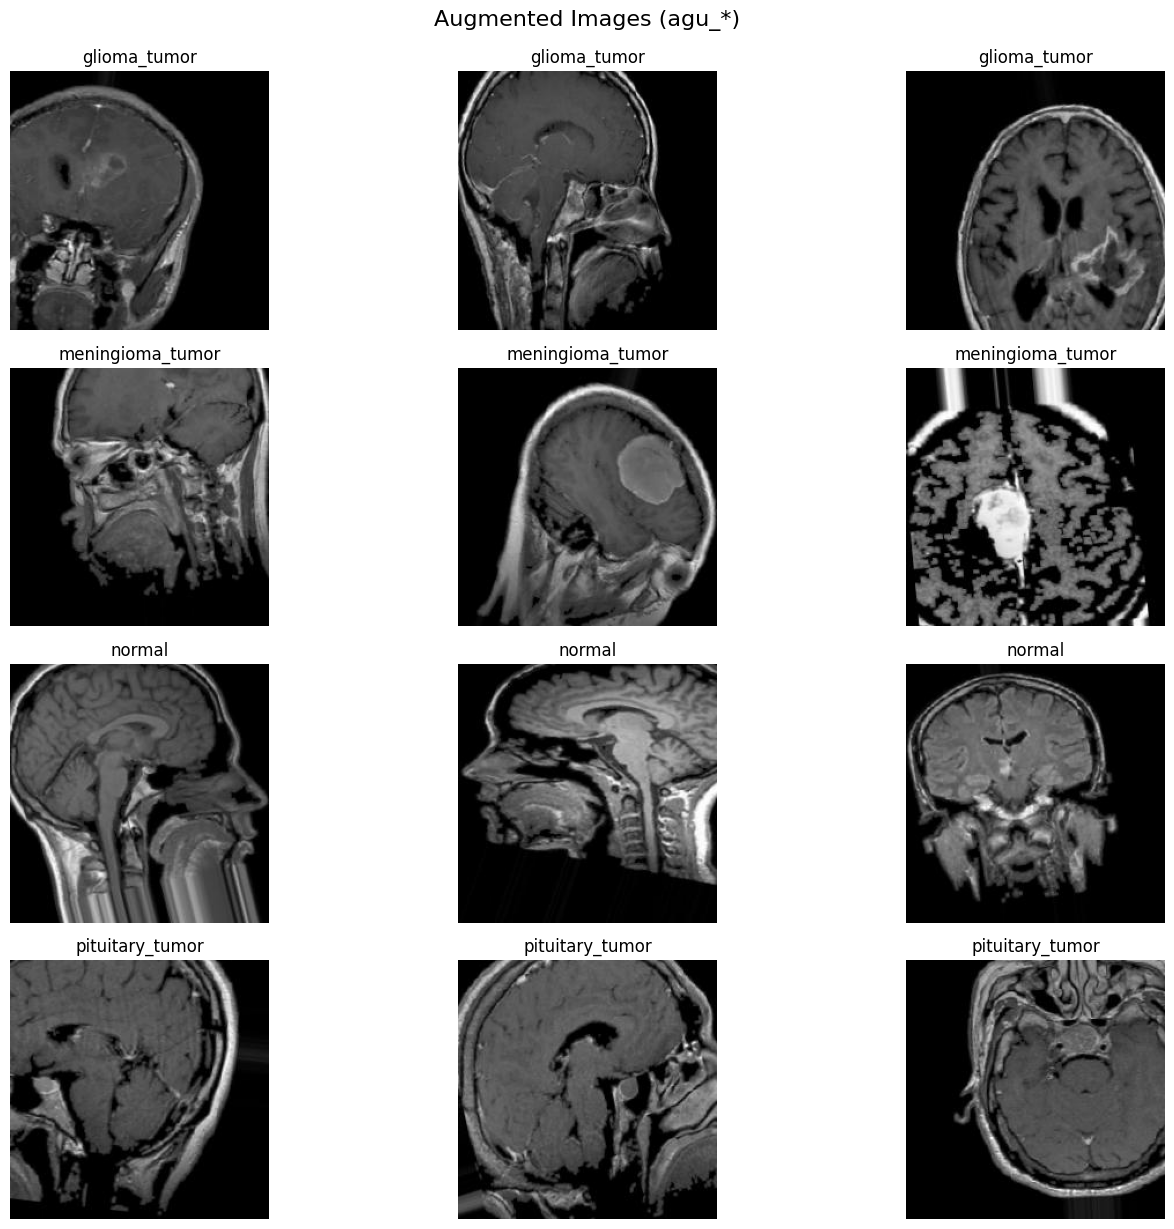

In [ ]:
num_images_per_class = 3  # Adjust as needed
# Set up plot
plt.figure(figsize=(15, 12))
img_index = 1

for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    images = [f for f in os.listdir(class_dir) if f.startswith('aug_') and f.endswith(('.jpg', '.jpeg', '.png'))]

    if len(images) == 0:
        print(f"No augmented images found for {class_name}")
        continue

    selected_images = random.sample(images, min(num_images_per_class, len(images)))

    for img_name in selected_images:
        try:
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=(224, 224))
            plt.subplot(len(classes), num_images_per_class, img_index)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis('off')
            img_index += 1
        except UnidentifiedImageError:
            print(f"Could not load image {img_name}, skipping.")
            continue

plt.tight_layout()
plt.suptitle("Augmented Images (agu_*)", fontsize=16, y=1.02)
plt.show()

# **Design, Train, and Evaluate a Baseline Model**

**Prepare training and validation generators**

In [ ]:
# Image and training parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20

# Prepare training and validation generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% of training data used for validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # sparse because we'll use sparse_categorical_crossentropy
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

# Test data generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data loader
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 2391 images belonging to 4 classes.
Found 596 images belonging to 4 classes.
Found 621 images belonging to 4 classes.


**Model Architecture**

In [ ]:
# # Define the Base CNN model
# base_model = Sequential([
#     # First Convolutional Block
#     Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     MaxPooling2D((2, 2)),

#     # Second Convolutional Block
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),

# Define a simple Baseline CNN model
model = keras.Sequential([
    # First Input Layer
    layers.Conv2D(32, (3, 3),padding="same", strides=1, activation="relu", input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2),strides=2),

    # Second Input Layer
    layers.Conv2D(64, (3, 3),padding="same", strides=1, activation="relu"),
    layers.MaxPooling2D((2, 2),strides=2),

    # Third Input Layer
    layers.Conv2D(128, (3, 3),padding="same", strides=1, activation="relu"),
    layers.MaxPooling2D((2, 2),strides=2),

    # Flatten to transition to fully connected layers
    layers.Flatten(),

    # First Fully Connected Layer
    layers.Dense(128, activation="relu"),

    # Second Fully Connected Layer
    layers.Dense(64, activation="relu"),

    # Third Fully Connected Layer
    layers.Dense(32, activation="relu"),

    # Output Layer
    layers.Dense(4, activation="softmax")  # 4 classes: glioma, meningioma, normal, pituitary

])

# Compile Model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Print Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,298,148 (16.40 MB)

 Trainable params: 4,298,148 (16.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Train the model
# basemodel_history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=EPOCHS
# )

# Compute model complexity
baseline_params = model.count_params()
print(f"\nBaseline Model Parameters: {baseline_params:,}")

# Train with timing
start_time = time.time()
basemodel_history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)
end_time = time.time()

baseline_training_time = end_time - start_time
print(f"\nBaseline Model Training Time: {baseline_training_time:.2f} seconds")


Baseline Model Parameters: 4,298,148


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - accuracy: 0.3733 - loss: 1.3078 - val_accuracy: 0.5017 - val_loss: 1.2425
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.5977 - loss: 0.9490 - val_accuracy: 0.5386 - val_loss: 1.2175
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.6855 - loss: 0.7906 - val_accuracy: 0.6393 - val_loss: 0.8079
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.7967 - loss: 0.5031 - val_accuracy: 0.6510 - val_loss: 0.8213
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.8735 - loss: 0.3433 - val_accuracy: 0.7668 - val_loss: 0.6786
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.9237 - loss: 0.2153 - val_accuracy: 0.7819 - val_loss: 0.6015
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.9529 - loss: 0.1298 - val_accuracy: 0.7550 - val_loss: 0.8355
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.9781 - loss: 0.0743 - val_accu

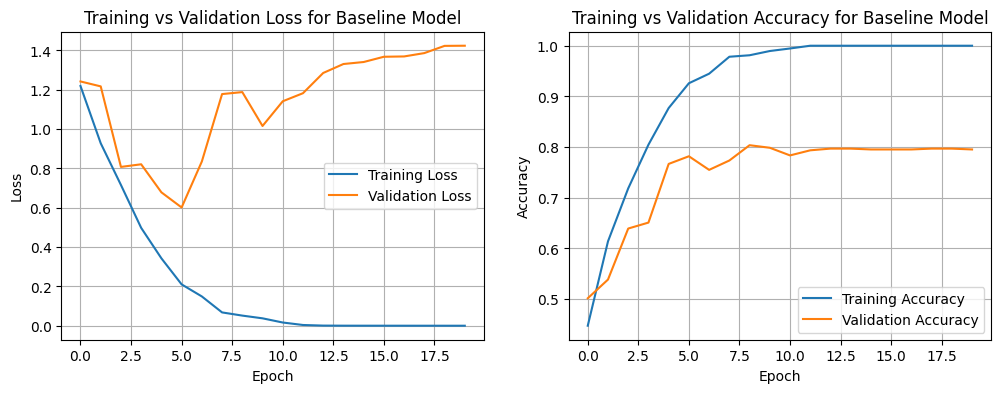

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(12, 4))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(basemodel_history.history['loss'], label='Training Loss')
plt.plot(basemodel_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss for Baseline Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(basemodel_history.history['accuracy'], label='Training Accuracy')
plt.plot(basemodel_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy for Baseline Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.8269 - loss: 1.3952

Test Accuracy: 0.8374
Test Loss: 1.2824


In [ ]:
# Get true labels
true_labels = test_generator.classes

# Get predicted probabilities and convert to class labels
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

class_labels = list(test_generator.class_indices.keys())
basemodel_report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("\nClassification Report of Baseline Model:\n")
print(basemodel_report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step
Accuracy:  0.8374
Precision: 0.8383
Recall:    0.8374
F1 Score:  0.8369

Classification Report of Baseline Model:

                  precision    recall  f1-score   support

    glioma_tumor       0.85      0.86      0.85       181
meningioma_tumor       0.82      0.75      0.78       183
          normal       0.76      0.86      0.81        88
 pituitary_tumor       0.89      0.89      0.89       169

        accuracy                           0.84       621
       macro avg       0.83      0.84      0.83       621
    weighted avg       0.84      0.84      0.84       621



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


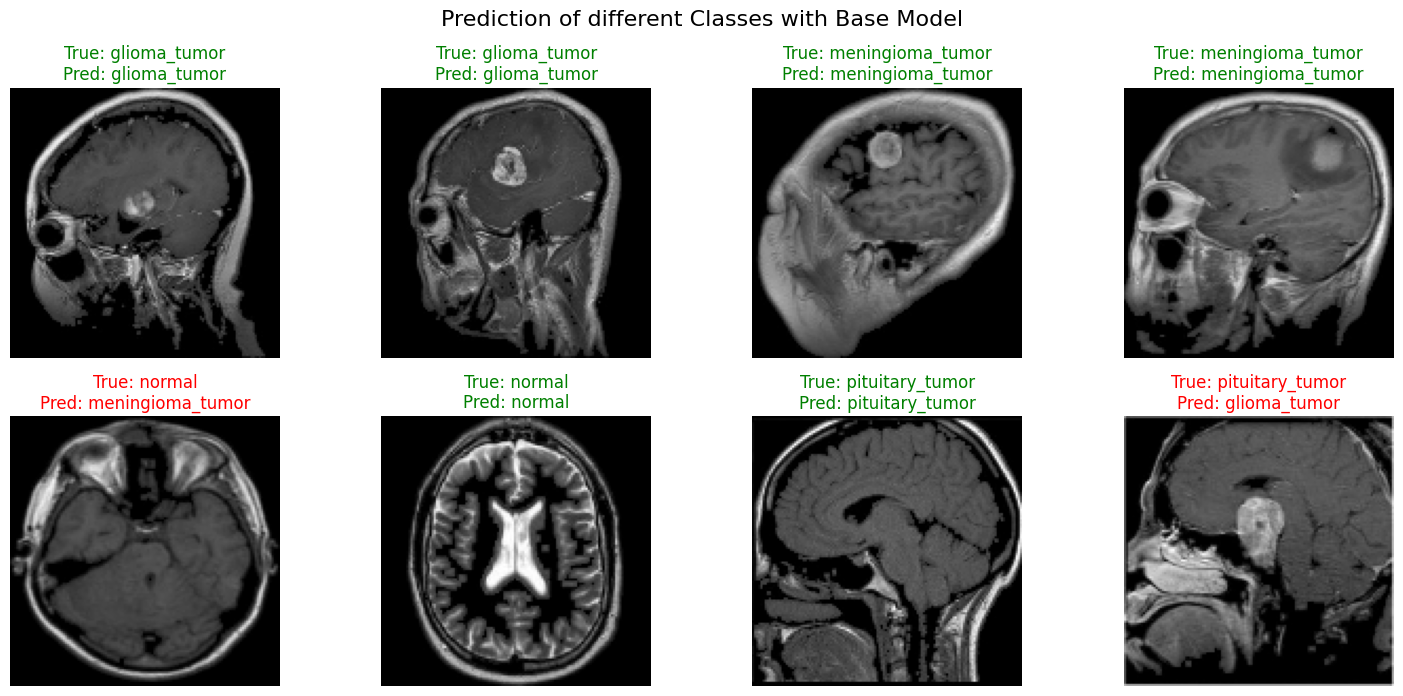

In [ ]:
# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Sample a few test images
sample_images = []
true_classes = []
for class_name in class_labels:
    class_dir = os.path.join(test_dir, class_name)
    images = os.listdir(class_dir)[:2]  # 2 images per class
    for img_name in images:
        sample_images.append(os.path.join(class_dir, img_name))
        true_classes.append(class_name)

# Plot predictions
plt.figure(figsize=(15, 10))

for i, img_path in enumerate(sample_images):
    # Load image
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    true_class = true_classes[i]

    # Color: green if correct, red otherwise
    color = "green" if predicted_class == true_class else "red"

    # Plot
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_class}\nPred: {predicted_class}", color=color)

plt.tight_layout()
plt.suptitle("Prediction of different Classes with Base Model", fontsize=16, y=1.02)
plt.show()

# **Design, Train , and Evaluate Deeper Architecture with Regularization Layer**

### **Deeper Model Architecture with Adam Optimizer**

In [ ]:
# Build deeper, regularized model
deeper1_model = keras.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Block 4
    layers.Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    # Block 5
    layers.Conv2D(512, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.6),

    # Fully Connected Layers
    layers.Flatten(),

    # First FCN
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),

    # Second FCN
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.25),

    # Third FCN
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),

    #Fourth FCN
    layers.Dense(64, activation="relu"),

    #Output Layer
    layers.Dense(4, activation="softmax")  # 4 classes
])

# Compile the model
deeper1_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Show model architecture
deeper1_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,806,692 (22.15 MB)

 Trainable params: 5,804,708 (22.14 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compute model complexity
deeper1_params = deeper1_model.count_params()
print(f"\nDeeper Model Parameters: {deeper1_params:,}")

# Train with timing
start_time = time.time()
deeper1_history = deeper1_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop]
)
end_time = time.time()

deeper1_training_time = end_time - start_time
print(f"\nDeeper Model Training Time: {deeper1_training_time:.2f} seconds")


Deeper Model Parameters: 5,806,692
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 372ms/step - accuracy: 0.2929 - loss: 3.7677 - val_accuracy: 0.2634 - val_loss: 2.8202
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.3525 - loss: 2.7958 - val_accuracy: 0.3205 - val_loss: 2.7564
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.3841 - loss: 2.6428 - val_accuracy: 0.2466 - val_loss: 2.6987
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.4421 - loss: 2.4992 - val_accuracy: 0.3574 - val_loss: 2.6149
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.5128 - loss: 2.3050 - val_accuracy: 0.2366 - val_loss: 3.1441
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.5882 - loss: 2.0939 - val_accuracy: 0.3138 - val_loss: 4.9579
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.6510 - loss: 1.9544 - val_accuracy: 0.3574 - val_loss: 4.6844
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accura

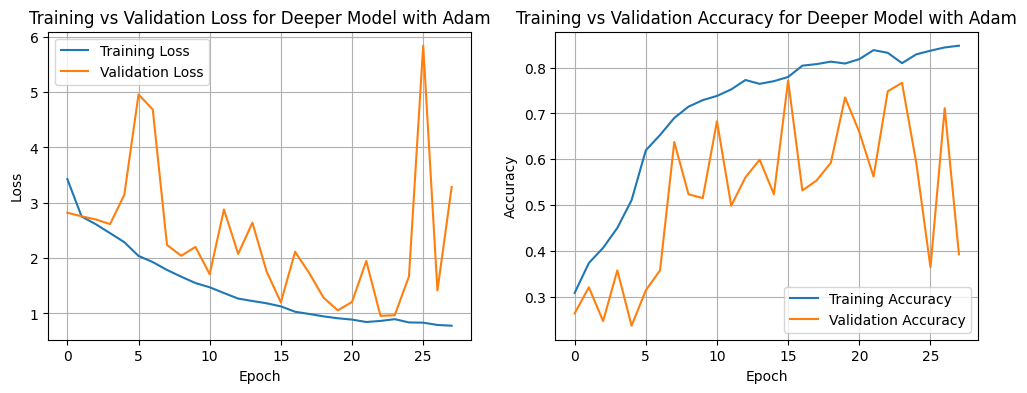

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(12, 4))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(deeper1_history.history['loss'], label='Training Loss')
plt.plot(deeper1_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss for Deeper Model with Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(deeper1_history.history['accuracy'], label='Training Accuracy')
plt.plot(deeper1_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy for Deeper Model with Adam')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = deeper1_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.5995 - loss: 1.2128

Test Accuracy: 0.7295
Test Loss: 1.0480


In [ ]:
# Get true labels
true_labels = test_generator.classes

# Get predicted probabilities and convert to class labels
pred_probs = deeper1_model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

class_labels = list(test_generator.class_indices.keys())
deep1_report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("\nClassification Report of Deeper Model with Adam Optimizer:\n")
print(deep1_report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step
Accuracy:  0.7295
Precision: 0.7777
Recall:    0.7295
F1 Score:  0.7195

Classification Report of Deeper Model with Adam Optimizer:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.49      0.65       181
meningioma_tumor       0.64      0.65      0.64       183
          normal       0.61      0.97      0.75        88
 pituitary_tumor       0.78      0.95      0.86       169

        accuracy                           0.73       621
       macro avg       0.76      0.76      0.73       621
    weighted avg       0.78      0.73      0.72       621



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


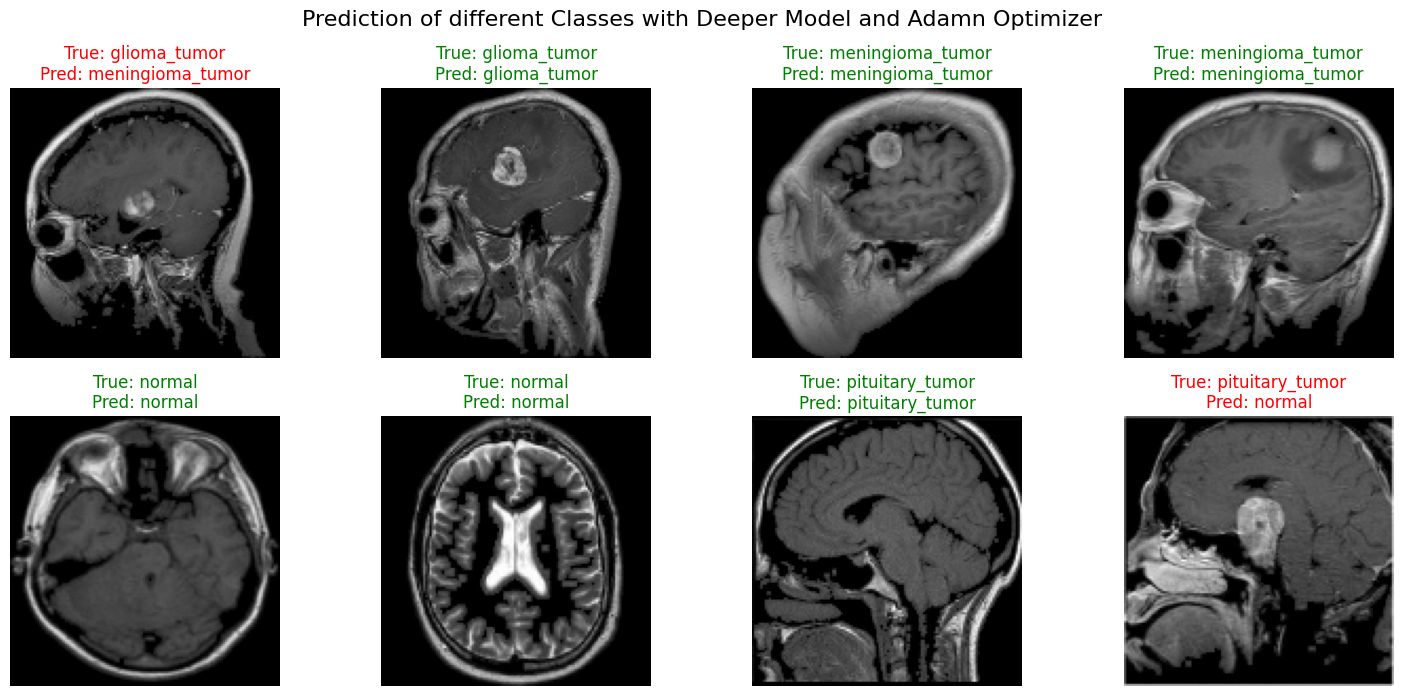

In [ ]:
# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Sample a few test images
sample_images = []
true_classes = []
for class_name in class_labels:
    class_dir = os.path.join(test_dir, class_name)
    images = os.listdir(class_dir)[:2]  # 2 images per class
    for img_name in images:
        sample_images.append(os.path.join(class_dir, img_name))
        true_classes.append(class_name)

# Plot predictions
plt.figure(figsize=(15, 10))

for i, img_path in enumerate(sample_images):
    # Load image
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = deeper1_model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    true_class = true_classes[i]

    # Color: green if correct, red otherwise
    color = "green" if predicted_class == true_class else "red"

    # Plot
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_class}\nPred: {predicted_class}", color=color)

plt.tight_layout()
plt.suptitle("Prediction of different Classes with Deeper Model and Adamn Optimizer", fontsize=16, y=1.02)
plt.show()

# **Comparision and Analysis**

### **Baseline vs. Deeper Model Performance**

In [ ]:
# Get true labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Function to evaluate a model
def evaluate_model(model, model_name):
    pred_probs = model.predict(test_generator)
    pred_labels = np.argmax(pred_probs, axis=1)

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    report_dict = classification_report(true_labels, pred_labels, target_names=class_labels, output_dict=True)

    print(f"\nClassification Report of {model_name}:\n")
    print(classification_report(true_labels, pred_labels, target_names=class_labels))

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Report": report_dict
    }

# Evaluate baseline and deeper (Adam) models
baseline_results = evaluate_model(model, "Baseline Model")
adam_results = evaluate_model(deeper1_model, "Deeper Model with Adam Optimizer")

# Compare overall metrics
overall_comparison = pd.DataFrame([
    {"Metric": "Accuracy", "Baseline": baseline_results["Accuracy"], "Adam": adam_results["Accuracy"]},
    {"Metric": "Precision", "Baseline": baseline_results["Precision"], "Adam": adam_results["Precision"]},
    {"Metric": "Recall", "Baseline": baseline_results["Recall"], "Adam": adam_results["Recall"]},
    {"Metric": "F1 Score", "Baseline": baseline_results["F1 Score"], "Adam": adam_results["F1 Score"]}
])

print("\nOverall Performance Comparison:\n")
print(overall_comparison)

# Class-wise comparison
class_comparison = pd.DataFrame({
    cls: {
        "Baseline Precision": baseline_results["Report"][cls]["precision"],
        "Adam Precision": adam_results["Report"][cls]["precision"],
        "Baseline Recall": baseline_results["Report"][cls]["recall"],
        "Adam Recall": adam_results["Report"][cls]["recall"],
        "Baseline F1": baseline_results["Report"][cls]["f1-score"],
        "Adam F1": adam_results["Report"][cls]["f1-score"]
    }
    for cls in class_labels
}).T

print("\nClass-wise Metrics Comparison:\n")
print(class_comparison)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step

Classification Report of Baseline Model:

                  precision    recall  f1-score   support

    glioma_tumor       0.85      0.86      0.85       181
meningioma_tumor       0.82      0.75      0.78       183
          normal       0.76      0.86      0.81        88
 pituitary_tumor       0.89      0.89      0.89       169

        accuracy                           0.84       621
       macro avg       0.83      0.84      0.83       621
    weighted avg       0.84      0.84      0.84       621

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step

Classification Report of Deeper Model with Adam Optimizer:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.49      0.65       181
meningioma_tumor       0.64      0.65      0.64       183
          normal       0.61      0.97      0.75        88
 pituitary_tumor       0.78      0.95      0.86       169

        accuracy                           0.73       6

## **Computational Efficiency**

In [ ]:
comparison_df = pd.DataFrame({
    "Model": ["Baseline", "Deeper (Adam Optimizer)"],
    "Training Time (s)": [baseline_training_time, deeper1_training_time],
    "Total Parameters": [baseline_params, deeper1_params]
})

print("\nModel Training Time and Computational Cost Comparison:\n")
print(comparison_df)


Model Training Time and Computational Cost Comparison:

                     Model  Training Time (s)  Total Parameters
0                 Baseline         256.171399           4298148
1  Deeper (Adam Optimizer)         408.970707           5806692


## **Optimizer Analysis: SGD vs Adam**

### **Deeper Model Architecture with SGD Optimizer**

In [ ]:
# Define regularized deeper CNN model with SGD Optimizer
deeper2_model = keras.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Block 4
    layers.Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    # Block 5
    layers.Conv2D(512, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.6),

    # Block 6
    layers.Conv2D(1024, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(1024, (3, 3), padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.7),

    # Fully Connected Layers
    layers.Flatten(),

    # First FCN
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),

    # Second FCN
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.25),

    # Third FCN
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),

    #Fourth FCN
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.1),

    # Fifth FCN
    layers.Dense(32, activation="relu"),

    #Output Layer
    layers.Dense(4, activation="softmax")  # 4 classes
])

# Define SGD optimizer with momentum
sgd = SGD(learning_rate=0.01, momentum=0.9)

# Compile the model
deeper2_model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
deeper2_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,611,268 (67.18 MB)

 Trainable params: 17,607,236 (67.17 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train the model
deeper2_history = deeper2_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop, lr_reduce]
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.2767 - loss: 4.3788
Epoch 1: val_accuracy improved from -inf to 0.39597, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 381ms/step - accuracy: 0.2771 - loss: 4.3776 - val_accuracy: 0.3960 - val_loss: 4.3463 - learning_rate: 0.0100
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3501 - loss: 4.1343
Epoch 2: val_accuracy did not improve from 0.39597
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.3501 - loss: 4.1340 - val_accuracy: 0.2534 - val_loss: 4.1633 - learning_rate: 0.0100
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3593 - loss: 4.0315
Epoch 3: val_accuracy did not improve from 0.39597
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.3595 - loss: 4.0308 - val_accuracy: 0.2500 - val_loss: 4.1022 - learning_rate: 0.0100
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4004 - loss: 3.8804
Epoch 4: val_accuracy did not improve from 0.39597
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.4008 - loss: 3.8799 - val_accuracy: 0.2500 - val_loss: 4.0644 - learning_rate: 0.0100
Epoch 5/50
75/75 ━━━━

75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.5428 - loss: 3.2788 - val_accuracy: 0.4312 - val_loss: 3.3924 - learning_rate: 0.0100
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5431 - loss: 3.2086
Epoch 11: val_accuracy did not improve from 0.43121
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.5435 - loss: 3.2079 - val_accuracy: 0.2534 - val_loss: 6.2478 - learning_rate: 0.0100
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6053 - loss: 3.0524
Epoch 12: val_accuracy did not improve from 0.43121
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.6053 - loss: 3.0523 - val_accuracy: 0.3339 - val_loss: 4.7005 - learning_rate: 0.0100
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5972 - loss: 2.9788
Epoch 13: val_accuracy improved from 0.43121 to 0.48490, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.5974 - loss: 2.9787 - val_accuracy: 0.4849 - val_loss: 3.2003 - learning_rate: 0.0100
Epoch 14/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6085 - loss: 2.9045
Epoch 14: val_accuracy did not improve from 0.48490
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.6088 - loss: 2.9041 - val_accuracy: 0.4581 - val_loss: 3.1497 - learning_rate: 0.0100
Epoch 15/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6212 - loss: 2.8516
Epoch 15: val_accuracy did not improve from 0.48490
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.6213 - loss: 2.8512 - val_accuracy: 0.4715 - val_loss: 3.3046 - learning_rate: 0.0100
Epoch 16/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6423 - loss: 2.7282
Epoch 16: val_accuracy did not improve from 0.48490
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.6420 - loss: 2.7286 - val_accuracy: 0.2601 - val_loss: 5.6914 - learning_rate: 0.0100
Epoch 17/50
75/

75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.6676 - loss: 2.6339 - val_accuracy: 0.4883 - val_loss: 3.2772 - learning_rate: 0.0050
Epoch 19/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6622 - loss: 2.5603
Epoch 19: val_accuracy did not improve from 0.48826
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.6627 - loss: 2.5595 - val_accuracy: 0.4161 - val_loss: 3.7686 - learning_rate: 0.0050
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 14.


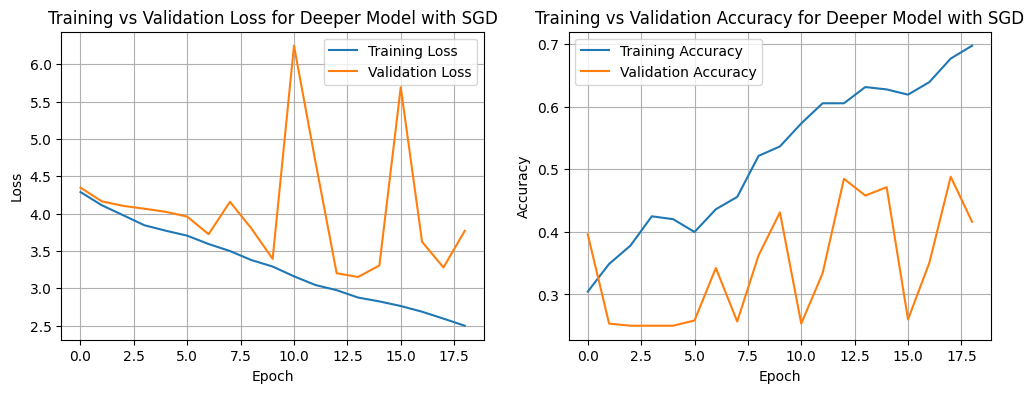

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(12, 4))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(deeper2_history.history['loss'], label='Training Loss')
plt.plot(deeper2_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss for Deeper Model with SGD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(deeper2_history.history['accuracy'], label='Training Accuracy')
plt.plot(deeper2_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy for Deeper Model with SGD')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = deeper2_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.5512 - loss: 3.0707

Test Accuracy: 0.4203
Test Loss: 3.1601


In [ ]:
# Get true labels
true_labels = test_generator.classes

# Get predicted probabilities and convert to class labels
pred_probs = deeper2_model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

class_labels = list(test_generator.class_indices.keys())
deep2_report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("\nClassification Report of Deeper Model with SGD Optimizer:\n")
print(deep2_report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step
Accuracy:  0.4203
Precision: 0.4604
Recall:    0.4203
F1 Score:  0.3866

Classification Report of Deeper Model with SGD Optimizer:

                  precision    recall  f1-score   support

    glioma_tumor       0.34      0.77      0.47       181
meningioma_tumor       0.27      0.08      0.13       183
          normal       0.69      0.33      0.45        88
 pituitary_tumor       0.68      0.46      0.54       169

        accuracy                           0.42       621
       macro avg       0.49      0.41      0.40       621
    weighted avg       0.46      0.42      0.39       621



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


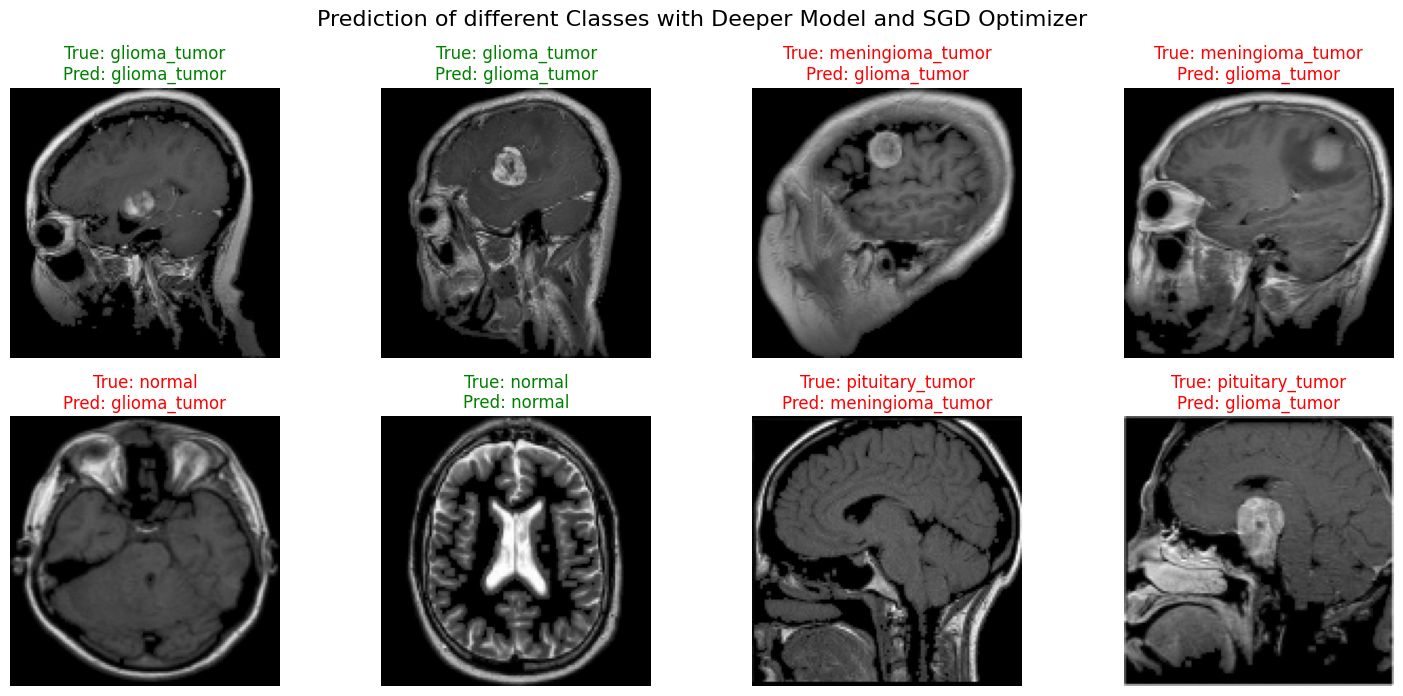

In [ ]:
# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Sample a few test images
sample_images = []
true_classes = []
for class_name in class_labels:
    class_dir = os.path.join(test_dir, class_name)
    images = os.listdir(class_dir)[:2]  # 2 images per class
    for img_name in images:
        sample_images.append(os.path.join(class_dir, img_name))
        true_classes.append(class_name)

# Plot predictions
plt.figure(figsize=(15, 10))

for i, img_path in enumerate(sample_images):
    # Load image
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = deeper2_model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    true_class = true_classes[i]

    # Color: green if correct, red otherwise
    color = "green" if predicted_class == true_class else "red"

    # Plot
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_class}\nPred: {predicted_class}", color=color)

plt.tight_layout()
plt.suptitle("Prediction of different Classes with Deeper Model and SGD Optimizer", fontsize=16, y=1.02)
plt.show()

### **Comparison Between Adam and SGD Optimizer**

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

# Get true labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Function to evaluate model
def evaluate_model(model, model_name):
    pred_probs = model.predict(test_generator)
    pred_labels = np.argmax(pred_probs, axis=1)

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    report = classification_report(true_labels, pred_labels, target_names=class_labels, output_dict=True)

    print(f"\nClassification Report of {model_name}:\n")
    print(classification_report(true_labels, pred_labels, target_names=class_labels))

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Report": report
    }

# Evaluate both models
results_adam = evaluate_model(deeper1_model, "Deeper Model with Adam Optimizer")
results_sgd = evaluate_model(deeper2_model, "Deeper Model with SGD Optimizer")

# Compare overall metrics
overall_comparison = pd.DataFrame([
    {"Metric": "Accuracy", "Adam": results_adam["Accuracy"], "SGD": results_sgd["Accuracy"]},
    {"Metric": "Precision", "Adam": results_adam["Precision"], "SGD": results_sgd["Precision"]},
    {"Metric": "Recall", "Adam": results_adam["Recall"], "SGD": results_sgd["Recall"]},
    {"Metric": "F1 Score", "Adam": results_adam["F1 Score"], "SGD": results_sgd["F1 Score"]}
])

print("\nOverall Performance Comparison:\n")
print(overall_comparison)

# Class-wise comparison
class_comparison = pd.DataFrame({
    cls: {
        "Adam Precision": results_adam["Report"][cls]["precision"],
        "SGD Precision": results_sgd["Report"][cls]["precision"],
        "Adam Recall": results_adam["Report"][cls]["recall"],
        "SGD Recall": results_sgd["Report"][cls]["recall"],
        "Adam F1": results_adam["Report"][cls]["f1-score"],
        "SGD F1": results_sgd["Report"][cls]["f1-score"]
    }
    for cls in class_labels
}).T

print("\nClass-wise Metrics Comparison:\n")
print(class_comparison)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step

Classification Report of Deeper Model with Adam Optimizer:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.49      0.65       181
meningioma_tumor       0.64      0.65      0.64       183
          normal       0.61      0.97      0.75        88
 pituitary_tumor       0.78      0.95      0.86       169

        accuracy                           0.73       621
       macro avg       0.76      0.76      0.73       621
    weighted avg       0.78      0.73      0.72       621

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step

Classification Report of Deeper Model with SGD Optimizer:

                  precision    recall  f1-score   support

    glioma_tumor       0.34      0.77      0.47       181
meningioma_tumor       0.27      0.08      0.13       183
          normal       0.69      0.33      0.45        88
 pituitary_tumor       0.68      0.46      0.54       169

        accuracy                      

# **Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning)**

## **ResNet50 Pretrained Model**

In [ ]:
# Load pre-trained ResNet50 base (exclude top FC layers)
resnet_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

# Freeze base layers
resnet_base.trainable = False

# Build the new model
transfer_model = models.Sequential([
    resnet_base,

    # Feature extraction output (from ResNet)
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    # Custom FC layers (deeper version)
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),

    # Output layer
    layers.Dense(4, activation='softmax')  # 4 output classes
])

# Compile model
transfer_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Show summary
transfer_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,817,732 (94.67 MB)

 Trainable params: 1,225,924 (4.68 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [ ]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
transfer_history = transfer_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stop]
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 334ms/step - accuracy: 0.3745 - loss: 1.2788 - val_accuracy: 0.3087 - val_loss: 1.4266
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.5726 - loss: 1.0194 - val_accuracy: 0.2685 - val_loss: 1.6393
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.6561 - loss: 0.8236 - val_accuracy: 0.4195 - val_loss: 1.4108
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.6927 - loss: 0.7828 - val_accuracy: 0.4648 - val_loss: 1.1668
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.7227 - loss: 0.7168 - val_accuracy: 0.5302 - val_loss: 1.1505
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.7476 - loss: 0.6647 - val_accuracy: 0.5554 - val_loss: 1.0633
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.7478 - loss: 0.6372 - val_accuracy: 0.6829 - val_loss: 0.9392
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.7815 - loss: 0.5610 - val_accu

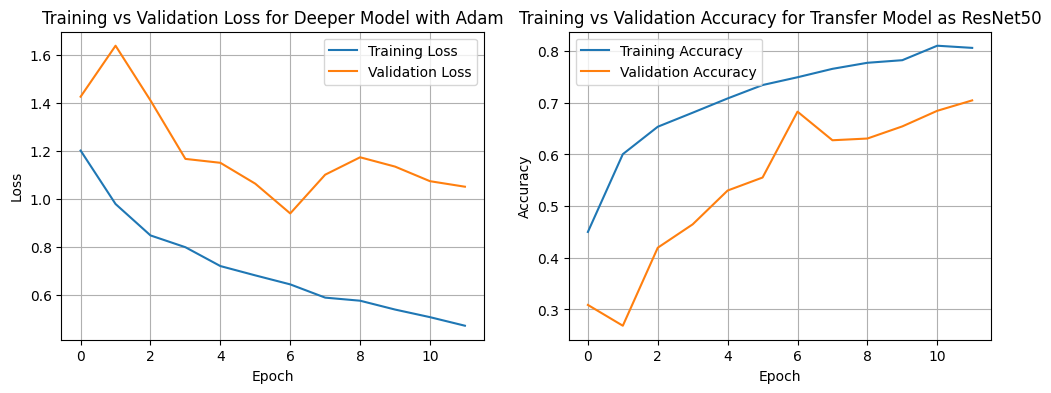

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(12, 4))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(transfer_history.history['loss'], label='Training Loss')
plt.plot(transfer_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss for Deeper Model with Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(transfer_history.history['accuracy'], label='Training Accuracy')
plt.plot(transfer_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy for Transfer Model as ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = transfer_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.6959 - loss: 0.8191

Test Accuracy: 0.7343
Test Loss: 0.7239


In [ ]:
# Get true labels
true_labels = test_generator.classes

# Get predicted probabilities and convert to class labels
pred_probs = transfer_model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

class_labels = list(test_generator.class_indices.keys())
transfer_report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("\nClassification Report of Transfer Model as ResNet50:\n")
print(transfer_report)

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step
Accuracy:  0.7343
Precision: 0.7324
Recall:    0.7343
F1 Score:  0.7321

Classification Report of Transfer Model as ResNet50:

                  precision    recall  f1-score   support

    glioma_tumor       0.72      0.71      0.71       181
meningioma_tumor       0.70      0.62      0.66       183
          normal       0.72      0.81      0.76        88
 pituitary_tumor       0.79      0.85      0.82       169

        accuracy                           0.73       621
       macro avg       0.73      0.75      0.74       621
    weighted avg       0.73      0.73      0.73       621



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


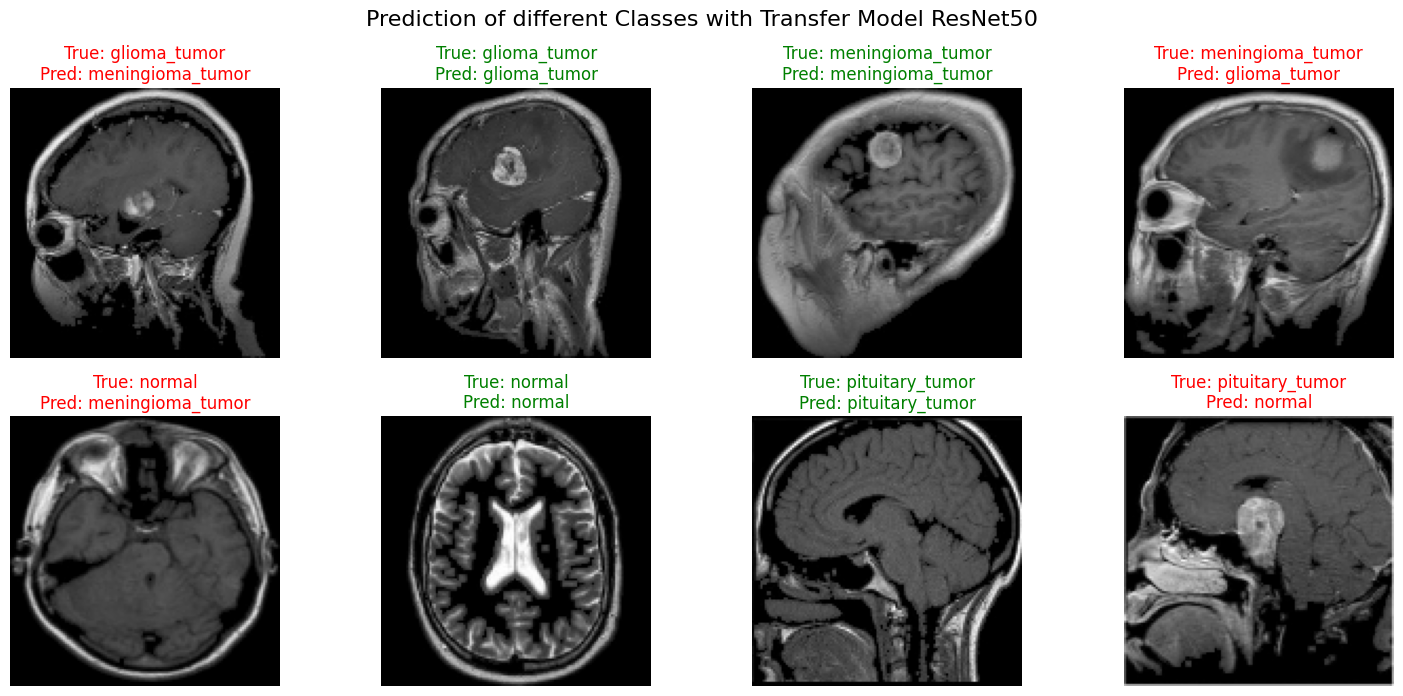

In [ ]:
# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Sample a few test images
sample_images = []
true_classes = []
for class_name in class_labels:
    class_dir = os.path.join(test_dir, class_name)
    images = os.listdir(class_dir)[:2]  # 2 images per class
    for img_name in images:
        sample_images.append(os.path.join(class_dir, img_name))
        true_classes.append(class_name)

# Plot predictions
plt.figure(figsize=(15, 10))

for i, img_path in enumerate(sample_images):
    # Load image
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = transfer_model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    true_class = true_classes[i]

    # Color: green if correct, red otherwise
    color = "green" if predicted_class == true_class else "red"

    # Plot
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_class}\nPred: {predicted_class}", color=color)

plt.tight_layout()
plt.suptitle("Prediction of different Classes with Transfer Model ResNet50", fontsize=16, y=1.02)
plt.show()